In [15]:
# Required Libraries
import cv2 as cv 
import numpy as np
import os
from matplotlib import pyplot as plt

In [16]:
saltPepperImage = cv.imread('Images/SaltPepperNoise_2.jpg',cv.IMREAD_GRAYSCALE)

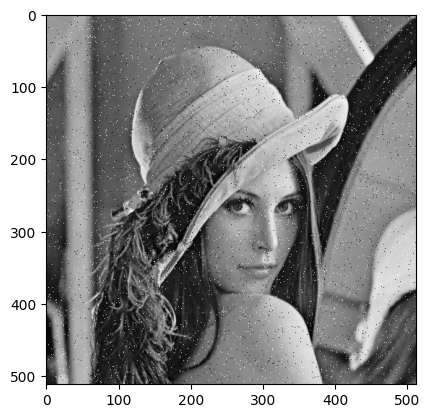

In [17]:
plt.imshow(saltPepperImage,cmap='gray',vmin=0,vmax=255)

We have 3 kernel size 3x3 5x5 7x7

In [18]:
def adaptive_median_filter(image, minFilterSize, maxFilterSize):
    m,n = image.shape
    filteredImage = np.zeros((m,n)).astype(np.uint8)
    max_padded_image = image_padding(image,maxFilterSize)
    for i in range (m):
        for j in range(n):
            filteredImage[i][j]=adaptive_median_filter_single_pixel(max_padded_image,[i,j],minFilterSize,maxFilterSize)
    return filteredImage

def image_padding(image,maxFilterKernel):
    paddingNumber = int(maxFilterKernel/2)
    top_line = image[0]
    bottom_line = image[-1]
    image_upper_padding = image.copy()
    for i in range(paddingNumber):
        image_upper_padding = np.vstack((top_line,image_upper_padding,bottom_line))
    left_line = image_upper_padding[:,0]
    right_line = image_upper_padding[:,-1]
    for i in range(paddingNumber):
        image_upper_padding = np.column_stack((left_line,image_upper_padding,right_line))
    return image_upper_padding

def adaptive_median_filter_single_pixel(image_padded,index_x_y,currKernelSize,maxKernelSize):
    slice = image_padded[index_x_y[0]+int((maxKernelSize-currKernelSize)/2):index_x_y[0]+int((maxKernelSize+currKernelSize)/2),index_x_y[1]+int((maxKernelSize-currKernelSize)/2):index_x_y[1]+int((maxKernelSize+currKernelSize)/2)].flatten()
    slice_sorted = np.sort(slice)
    slice_sorted_med = slice_sorted[int((currKernelSize**2)/2)]
    if np.min(slice_sorted) < slice_sorted_med < np.max(slice_sorted):
        pixel_value = image_padded[index_x_y[0]+int(maxKernelSize/2),index_x_y[1]+int(maxKernelSize/2)]
        if np.min(slice_sorted) < pixel_value < np.max(slice_sorted):
            return pixel_value
        else:
            return slice_sorted_med
    elif currKernelSize+2 == maxKernelSize:
        return slice_sorted_med
    else:
        return adaptive_median_filter_single_pixel(image_padded,index_x_y,currKernelSize+2,maxKernelSize)


In [19]:
filtered_image_result = adaptive_median_filter(saltPepperImage,3,7)

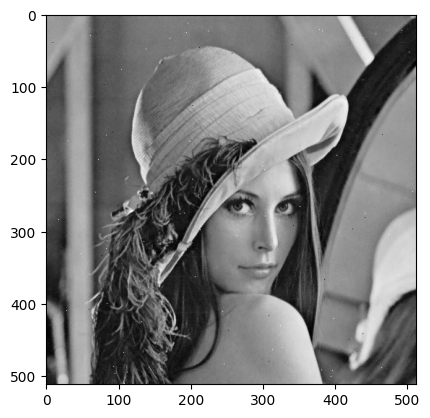

In [20]:
plt.imshow(filtered_image_result,cmap='gray',vmin=0,vmax=255)

Adaptive median filter executes approximately in 14 seconds in my virtual box Ubuntu environment

In [21]:
output_2_2 = cv.medianBlur(saltPepperImage,3)
output_2_3 = cv.medianBlur(saltPepperImage,5)
output_2_4 = cv.medianBlur(saltPepperImage,7)

def center_weighted_median_filter(image,kernel_size):
    # We can use image_border_padded from before
    m,n = image.shape
    weighted_median_filter_image = np.zeros((m,n))
    image_border_padded = image_padding(image,kernel_size)
    for i in range(m):
        for j in range(n):
            all_values = image_border_padded[i:i+kernel_size,j:j+kernel_size].flatten()
            mid_value = image_border_padded[i+int(kernel_size/2)][j+int(kernel_size/2)]
            # values_to_append = [mid_value, mid_value]
            all_values_weighted = np.append(all_values, [mid_value,mid_value])
            # new_arr = np.append(arr, values_to_append)
            weighted_median_filter_image[i,j]=np.sort(all_values_weighted)[int(len(all_values_weighted)/2)]
    return weighted_median_filter_image.astype(np.uint8)
output_2_5 = center_weighted_median_filter(saltPepperImage,3)
output_2_6 = center_weighted_median_filter(saltPepperImage,5)
output_2_7 = center_weighted_median_filter(saltPepperImage,7)


In [22]:
# Compare 7 filters by getting PSNRs
original_image = cv.imread("Images/cleanImage.jpg",cv.IMREAD_GRAYSCALE)

# Calculate PSNR
psnr_my_adaptive_median_filter = cv.PSNR(original_image, filtered_image_result)
psnr_opencv_3_3_median = cv.PSNR(original_image, output_2_2)
psnr_opencv_5_5_median = cv.PSNR(original_image, output_2_3)
psnr_opencv_7_7_median = cv.PSNR(original_image, output_2_4)
psnr_my_center_weighted_3_3_median = cv.PSNR(original_image, output_2_5)
psnr_my_center_weighted_5_5_median = cv.PSNR(original_image, output_2_6)
psnr_my_center_weighted_7_7_median = cv.PSNR(original_image, output_2_7)

print("PSNR: My Adaptive Median (3x3 to 7x7)", psnr_my_adaptive_median_filter)
print("PSNR: OpenCv median (3x3)", psnr_opencv_3_3_median)
print("PSNR: OpenCv median (5x5)", psnr_opencv_5_5_median)
print("PSNR: OpenCv median (7x7)", psnr_opencv_7_7_median)
print("PSNR: My Weighted Median Filter (3x3)", psnr_my_center_weighted_3_3_median)
print("PSNR: My Weighted Median Filter (5x5)", psnr_my_center_weighted_5_5_median)
print("PSNR: My Weighted Median Filter (7x7)", psnr_my_center_weighted_7_7_median)


PSNR: My Adaptive Median (3x3 to 7x7) 34.909181866629815
PSNR: OpenCv median (3x3) 33.509311680314184
PSNR: OpenCv median (5x5) 29.830583699377243
PSNR: OpenCv median (7x7) 27.76026993903325
PSNR: My Weighted Median Filter (3x3) 36.27456893658604
PSNR: My Weighted Median Filter (5x5) 31.0135842014116
PSNR: My Weighted Median Filter (7x7) 28.353177114845444


# My Adaptive median Filter implamentation works better than others for first image sample
# But for SaltPepperNoise2 it's performance decrease significantly